<a id='beginning'></a>
# Machine Learning Challenge
#### Student: Andrea Contenta
#### Professor: Thibaud Vienne




The workbook is organized as follows:


0. **Prerequisites**:
    >- about data
    >- load modules
    >- functions


1. **Data exploration**:
    >- load data and set index
    >- look at the distribution of the target
    >- data visualization
    >- correlation matrix
    
    
2. **Features engineering and selection**:
    >- compute new features
    >- PCA
    >- features selection
    
3. **Machine Learning algorithms experiments**:
    >- validation procedure: random forest, xgboost, LASSO, neural network
    >- tuned candidate models
   
4. **Final run**:
    >- run best model and make predictions on validation set
    >- interpretation
    >- conclusion

# Step 0 - Prerequisites

<a id='0.1'></a>
## 0.1) About data

Dimension : Less than 1,000,000 rows, including 200,000 bid-ask spreads to predict.


> - **product_id** and **liquidity_rank** define a unique futures contract. The dataset contains around 100 product_id (corresponding for instance to a specific type of crude oil). For each product_id several liquidity ranks can exist: liquidity_rank 0 refers to the contract with the closest expiry date (which is often the most traded one), 1 to the next contract to expire, etc. Thus, a contract of rank 1 becomes a contract of rank 0 when the previous contract of rank 0 expires.
> - **dt_close** represents the day number (they are therefore chronological) for each data sample. For a given dt_close there is 1 entry per (product_id, liquidity_rank) pair.
> - **dt_expiry** similarly represents the date of the futures contract expiry.
> - **normal_trading_day** is set to 0 when the market is closed or the market activity is reduced.
> - **open**, **close** represent contract prices, resp. at market opening and close.
> - **high**, **low** represent the highest and lowest price of the contract during the day.
> - **volume** is the number of contracts exchanged during the day, up to a factor that depends only on product_id.
> - **open_interest** is the number of active contracts at the end of the day, with the same factor applied as for the volume.
> **spread** is the “daily bid-ask spread”, which is the value we want to predict.
> **tick_size** is a proxy for 1 unit of spread (this is not directly price difference).
> - **fixed** is set to 1 when one or more features have been fixed for various reason (outliers, missing values…).

Prices are all normalized in some way (the values are thus not in currency units), but they are consistent within each product_id.

<a id='0.2'></a>
## 0.2) Load modules

In this cell, you can put all modules you use. You can use it to provide a clear code.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA as PCA

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

<a id='0.3'></a>
## 0.3) Functions

In [25]:
def export_ens(df_test, pred_test, save=True, path_save="y_test_prediction.csv"):
    """
    Export submissions with the good ENS data challenge format.
    df_test : (pandas dataframe) test set
    proba_test : (numpy ndarray) prediction as a numpy ndarray you get using method .predict()
    save : (bool) if set to True, it will save csv submission in path_save path.
    path_save : (str) path where to save submission.
    return : dataframe for submission
    """
    df_submit = pd.Series(pred_test[:], index=df_test.index, name="spread")
    df_submit.to_csv(path_save, index=True)
    return df_submit

def check_test(result, expected, display_error):
    """
    Testing your results.
    """
    if result == expected:
        print("1 test passed.")
    else:
        print(display_error)

# Reduce memory usage up to 60%
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def filter_data(df, column, position):
    """
    Data visualization tool
    """
    unique_keys = df[column].unique()
    return df[df[column]==unique_keys[position]]

def data_pipeline(df, pipe):
    """
    Apply different functions to the dataframe.
    df : (pandas dataframe) data to transform
    pip : (iterable of functions) functions to be applied to the data
    return : df with data transformed
    """
    error_log = []
    for func in tqdm(pipe):
        try:
            df = func(df)
        except Exception as e:
            error_log.append(f"An error occured while trying to apply {func.__name__} with error : {e}")
    print(*error_log, sep="\n")
    return df

def evaluate(df1, df2):  # TO CHECK #
    """
    Compute and prints RMSE for train and validation dataset of a given model
    """
    print("RMSE score on train dataset : %.4f" % mean_squared_error(df1, y_train, squared=False))
    print("RMSE score on validation dataset : %.4f" % mean_squared_error(df2, y_val, squared=False))
    
def rescue_me():
    """
    Re-load the dataset and perform manipulations on it
    """
    global df_train, y_train, df_test, df_full
  
  # overwrite dataframes
    df_train = pd.read_csv("C:/Users/andre/Downloads/input_training_imet9ZU.csv")
    y_train = pd.read_csv("C:/Users/andre/Downloads/output_training_yCN1f2d.csv")
    df_test = pd.read_csv("C:/Users/andre/Downloads/input_test_4AhEauI.csv")
    df_full = pd.concat([df_train,y_train], axis=1)
    df_train = df_train.set_index('ID')
    y_train = y_train.set_index('ID')
    df_test = df_test.set_index('ID')
    
    def maturity(df):
        return (df['dt_expiry'] - df['dt_close'])

    df_train['mat']=maturity(df_train)
    df_test['mat']=maturity(df_test)

    # compute mean_target_per_product
    mean_target_per_product = df_full.groupby(["product_id","liquidity_rank"])["spread"].mean()
    mean_target_per_product.name = "mean_target_per_product"
    df_train = df_train.merge(mean_target_per_product, how="left", right_index=True, left_on=["product_id", "liquidity_rank"])
    df_test = df_test.merge(mean_target_per_product, how="left", right_index=True, left_on=["product_id", "liquidity_rank"])

In [26]:
rescue_me()

<a id='1'></a>
# Step 1 - Data Exploration
Data exploration is a common part in a machine learning pipeline. In this section, you will import datasets, discover  features, provide data mining observations, investigate missing values and possible outliers. An exhaustive exploration is more likely to yield prowerful predictive models.

- Read the train dataset inputs and assign to the variable **df_train**.
- Read the train dataset labels and assign to the variable **y_train**.
- Read the test dataset inputs and assign to the variable **df_test**.
- Concat **df_train** and **y_train** to create **df_full**.
- Assign number of rows in train dataset and assign it to variable **n_rows_train**.
- Assign number of rows in test dataset and assign it to variable **n_rows_test**.

<a id='1.1'></a>
## 1.1) Load datasets, set ID as index

In [4]:
# when changing the name of the directory, recall to do it also in the function section regarding the "rescue_me" function (the last one)
df_train = pd.read_csv("C:/Users/andre/Downloads/input_training_imet9ZU.csv")
y_train = pd.read_csv("C:/Users/andre/Downloads/output_training_yCN1f2d.csv")
df_test = pd.read_csv("C:/Users/andre/Downloads/input_test_4AhEauI.csv")
df_full = pd.concat([df_train,y_train], axis=1)
n_rows_train = len(df_train)
n_rows_test = len(df_test)

In [5]:
print('Shapes')
print('------------------------')
print("df_train : %s" % str(df_train.shape))
print("y_train  : %s" % str(y_train.shape))
print("df_test  : %s" % str(df_test.shape))
print("df_full  : %s" % str(df_full.shape))

Shapes
------------------------
df_train : (629611, 14)
y_train  : (629611, 2)
df_test  : (230304, 14)
df_full  : (629611, 16)


In [6]:
check_test(n_rows_train, 629611, "wrong number of rows")
check_test(n_rows_test, 230304, "wrong number of rows")

1 test passed.
1 test passed.


In [7]:
df_train = df_train.set_index('ID')
y_train = y_train.set_index('ID')
df_test = df_test.set_index('ID')

In [8]:
check_test(df_train.shape[1], 13, "wrong number of columns")
check_test(y_train.shape, (629611, 1), "wrong number of columns")

1 test passed.
1 test passed.


Look at the type of data included in the train dataset:

In [ ]:
df_train.info()

<a id='1.2'></a>
## 1.2) Look at the distribution of the target

Let's take a look on the column label (spread) in the train dataset. Take a look on the disribution of the label by plotting an histogram with matplotlib.

- Plot the histogram of the serie **y_train**. You can use the parameter **bins** to change the number of slots.
- Describe the serie **y_train** using the method **.describe()**.

In [ ]:
# Plot the histogram
# to make the code faster you can select a random subsample of the population
plt.xlabel('spread')
plt.ylabel('frequency')
plt.suptitle('Distribution of spread')
plt.hist(y_train, bins=50)
plt.show()

# Describe the serie of label with the method .describe()
y_train.describe()

Mind that over all variables, many are just categorical variables expressed in numbers. Those variables don't need to be standardized. Rather, they should be one-hot-encoded:

- **categorical variables**: dt_close, product_id, liquidity_rank, normal_trading_day, dt_expiry (5)
- **numerical variables**: open, high, low, close, open_interest, volume, tick_size (7)

### Bid-ask spread with respect to the liquidity rank

Very naively, one might think that there is a relationship between the bid-ask spread and the liquidity rank. To verify this hypothesis, we can visualize the boxplot distribution per category rank.

In [ ]:
plt.figure(figsize=[15, 8])
ax = sns.boxplot(x='liquidity_rank', y='spread', data=df_full)
plt.title("Distribution of the target per liquidity rank")
plt.show()

<a id='1.3'></a>
## 1.3) Data visualization

In [ ]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_full['spread']).set(title='Distribution of spread')
plt.subplot(1,2,2)
sns.boxplot(df_full['spread']).set(title='Box-plot of spread')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(20, 8), facecolor='w', edgecolor='k',sharex=True, sharey=True)

axs = axs.ravel()
fig.suptitle('Spread and close price for each liquidity rank')
for i,ax in zip(range(0,12),axs):
    ax.scatter(df_full[df_full.liquidity_rank==i].close,df_full[df_full.liquidity_rank==i].spread)
    ax.set_xlabel('close')
    ax.set_ylabel('spread')

We see that the distribution of the data is very asymmetric with regard to the liquidity rank. So we want to investigate whether this asymmetry is also present in the validation dataset. If this is not the case, we would need to treat the data witha high liquidity rank (ie, less liquid) as outliers. If this is not the case, we need to figure out a way to model well those kind of extreme values.

In [ ]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1,1], aspect=1)
ax1.pie(df_train.liquidity_rank.value_counts(normalize=True), autopct='%1.1f%%', labels=range(0,12))
ax2 = fig.add_axes([1, 0, 1,1], aspect=1)
ax2.pie(df_test.liquidity_rank.value_counts(normalize=True), autopct='%1.1f%%', labels=range(0,12))
ax1.set_title('Liquidity rank frequency in train/test dataset')
ax2.set_title('Liquidity rank frequency in validation dataset')
plt.show()

We see that there is no substantial relative difference between the distribution of products with high liquidity rank in train/test dataset and in validation dataset. So there asre no outliers when ir comes to liquidity ranking.

In [ ]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_full['spread']).set(title='Distribution of spread')
plt.subplot(1,2,2)
sns.boxplot(df_full['spread']).set(title='Box-plot of spread')
plt.show()

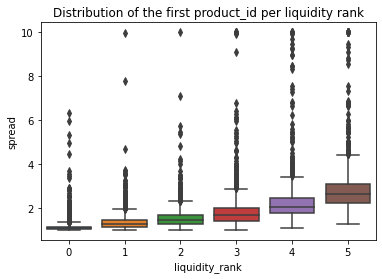

In [24]:
# Filter on the first product ID and then on liquidity rank

filter_pid = filter_data(df_full, 'product_id', 0)
filter_pid_liq = filter_data(filter_pid, 'liquidity_rank',0)

sns.boxplot(x='liquidity_rank', y='spread', data=filter_pid)
plt.title("Distribution of the first product_id per liquidity rank")
plt.show()

<a id='1.4'></a>
## 1.4) Correlation matrix

Correlation within features may increase the bias in our model:

In [ ]:
# Correlation matrix
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_train.corr()
corr
corr.style.background_gradient(cmap='coolwarm')

Correlation with the label may help us build a better model:

In [ ]:
corr_s=df_full.corr().iloc[:-2,-1].to_frame()
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr_s
corr_s.style.background_gradient(cmap='coolwarm')

No significant correlation spotted. No need to go through other methods like Variance Inflation Factor

Construct other variables to avoid correlation

<a id='2'></a>
# Step 2 - Features engineering and selection

According to the conclusions you get from step 1 exploration, process your data (features engineering, features selection, dimensionality reduction...). Feel free to create several different datasets if you want to explore different kind of dataframes.

 We reported the **one_hot_encoder** function but we finally we did not use it. This is because the ML algorithms we have chosen do not need this step: as both XGB and RF are basically built like a decision tree, then the 0-1 transformation made by the encoder is not needed anymore, since the tree will split in any case. Rather, this transformation is required when dealing with linear methods, such LASSO. In fact, categorical variables must be one-hot-encoded: their values do not mean anything in particular (ie do not have a numerical, or "magnitude", sense). Take for example liquidity rank: if we had to use only linear regression methods, we should have use OHE to create as many dummy variable as ranks, to make the regression correctly works.

In [ ]:
def one_hot_encoder(df, col_to_encode, col_is_int=True):
    """
    Performs One Hot Encoding with sklearn.
    df : pandas dataframe containing column to encode
    col_to_encode : (str) column name
    col_is_int : (bool) whether or not column is integer.
    """
    # Create the mapping
    if col_is_int: 
        integer_encoded = df[col_to_encode].values.reshape(-1, 1)
    else:
        values = df[col_to_encode].tolist()
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
    
    # One hot encoder
    ohe = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    df_temp = pd.DataFrame(ohe.fit_transform(integer_encoded), index=df.index)
    df_temp.columns = ["%s_%s" % (col_to_encode, col) for col in df_temp.columns]
    df_results = pd.concat([df, df_temp], axis=1)
    return df_results

<a id='2.1'></a>
## 2.1) Compute new features
Some variables may not be very much significant themselves. Rather, they can explain more if combined with other ones. This can be the example of *dt_expiry* and *dt_close*: while the two categorical variable do not tell us very much about the time horizon if taken separately, we can construct a **maturity** measure that can explain more than the single variables taken singularly.

In [9]:
def features_eng(df):
    global df_full
    def maturity(df):
      return (df['dt_expiry'] - df['dt_close'])
    def intraday_ret(df):
      return (df.close - df.open)/df.open
    def price_spread(df):
      return (df.high - df.low)

    df['mat']=maturity(df)
    df['in_ret']=intraday_ret(df)
    df['price_sp']=price_spread(df)

    mean_target_per_product = df_full.groupby(["product_id","liquidity_rank"])["spread"].mean()
    mean_target_per_product.name = "mean_target_per_product"
    df = df.merge(mean_target_per_product, how="left", right_index=True, left_on=["product_id", "liquidity_rank"])
    return df

In [10]:
df_train=features_eng(df_train)
df_test=features_eng(df_test)
df_full = pd.concat([df_train,y_train], axis=1)

In [ ]:
# Correlation matrix
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr2 = df_train.corr()
corr2
corr2.style.background_gradient(cmap='coolwarm')

A powerful way to visualize relationships between data is to use a **pairplot**

In [ ]:
sns.pairplot(df_full[['mat', 'in_ret', 'price_sp', 'liquidity_rank','spread']], diag_kind='kde')

We deduce the absence of any easily-spottable (linear) link between most of the features and the label. The only clear spottable link is the one maturity-liquidity_rank, which has been already identified before. So, we may want to search deeply for new features and use methods to reduce dimensionality of the dataset. We then implement PCA analysis to try reduce dimensionality of the dataset and to find some uncorrelated features.

<a id='2.2'></a>
### 2.2) PCA

In [ ]:
df_pca_x=df_full.iloc[:,:-1]
df_pca_y=df_full.iloc[:,-1]

In [ ]:
check_test(df_pca_x.shape, (len(df_full),17), "wrong size of df_pca_x. Current size is "+str(df_pca_x.shape))
check_test(df_pca_y.shape, (len(df_full),), "wrong size of df_pca_y")

In [ ]:
from sklearn.decomposition import PCA
x_train, x_val, y_train, y_val = train_test_split(df_pca_x, df_pca_y, test_size = 0.2, random_state = 203)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
pca = PCA()
x_train = pca.fit_transform(x_train)
x_val = pca.transform(x_val)
explained_variance = pca.explained_variance_ratio_
res_PCA = pd.DataFrame({'Expl. variance' : np.round(explained_variance,2)}, index = ['PCA' + str(i) for i in range(17)])

In [ ]:
res_PCA_c=np.cumsum(res_PCA)

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_axes([0, 0, 1,1])
ax1.plot(res_PCA)
ax2 = fig.add_axes([1, 0, 1,1])
ax2.plot(res_PCA_c)
ax1.set_title('PCA - Explained Variance')
ax2.set_title('PCA - Explained Cumulative Variance')
plt.show()

Having examined the plots of PCA results, we decide not to proceed with it as the first components only have a scarce explanatory power. Also, we will use some machine learning algorithms that are not particularly penalised by the presence of correlation between features. 

<a id='2.3'></a>
### 2.3) Features selection

In [ ]:
df_train.columns

After having examined the correlation matrix, we deduce that most of the variable are not significantly correlated with others, so this means that each one can significantly contribute to explain the label. We will utilize some machine learning algoriths that intrinsically detect the relative importance of the features (ie, by assigning a relative weight). This makes the task of features selection easier.

Though, we include the variables that we created, such as: *mat*, *in_ret*, and *price_sp* because they can apport an increased explanatory power.

We also cut off some prices since they are (as expected) very much correlated: *high*, *low*, *open*, and we only keep *close*.

In [13]:
features = [ 'dt_close', 'product_id', 'liquidity_rank', 'normal_trading_day', 'close', 'open_interest', 'volume','tick_size', 'fixed', 'mean_target_per_product', 'mat','in_ret', 'price_sp']

In [13]:
check_test("ID" not in features, True, "error : column ID still in the features.")

<a id='3'></a>
# Step 3 - Machine learning algorithms experiments

This section includes:
- validation procedure
- tuned candidate models

<a id='3.1'></a>
## 3.1) Validation procedure

In this section, we will split our dataset into a train set and a validation set. Asn an example, we will use the simple **train_test_split** approach. However, you are free to choose the validation procedure. Justify your choices.

- Using the train-test split approach, split your train dataframe. Assign the resulting dataframes to variables **x_train**, **x_val**, **y_train** and **y_val**.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_train[features], y_train, random_state=203, test_size=0.2)
x_test = df_test[features]

To try to predict missing bid-ask spread values, we will use the following machine learning algorithms:
- random forest
- XGBoost
- LASSO
- neural networks

<a id='3.1.1'></a>
### 3.1.1) Random forest

We start by running a **random forest** on all the dataset to see its explanatory power. We then proceed to estimate the optimal hyperparameters.

We prefer to run many one-by-one iterations, and not a single GridSearch (or similar methods), so as to visualise the learning curves (but also because they are very dispendious in terms of computational power). The learning curves will be the decision tool to assess the (pseudo-)optimal hyperparameters, under the constraint of overfitting minimisation.

We will proceed to the tuning of the following hyperparameters:
- max_depth
- min_sample_split
- min_sample_leaf
- n_estimators

and we will subsequently compute use this algorithms to compute featues importance.

<a id='max_depth'></a>
#### 3.1.1.1) Random forest: max_depth

In [ ]:
# RF parametrization : max_depth
depths = range(13, 20)
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_forest = []
all_rmsle_val_forest = []


for depth in depths: 

    # Random Forest
    clf_forest = RandomForestRegressor(n_estimators=100, max_depth=depth, n_jobs=-1)
    model_forest = clf_forest.fit(x_train, y_train.values.ravel())
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_forest],[all_rmsle_train_forest],[all_rmsle_val_forest],["forest"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("depth = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (depth, rmsle_train, rmsle_val, typ))

So we choose max_depth = 19

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(depths, all_rmsle_train, color="y", label="Random Forest - train")
plt.plot(depths, all_rmsle_val, color="r", label="Random Forest - validation")                                                  
plt.xlabel("tree depth")
plt.ylabel("RMSLE")
plt.title("Learning curves - max_depth")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

<a id='min_samples_split'></a>
#### 3.1.1.2) Random forest: min_samples_split

In [ ]:
# RF parametrization : min_samples_split
depth = 19
min_samples = range(2,8)
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_forest = []
all_rmsle_val_forest = []


for min_s in min_samples: 

    # Random Forest
    clf_forest = RandomForestRegressor(n_estimators=100, max_depth=depth, n_jobs=-1, min_samples_split=min_s)
    model_forest = clf_forest.fit(x_train, y_train.values.ravel())
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_forest],[all_rmsle_train_forest],[all_rmsle_val_forest],["forest"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("min_samples_split = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (min_s, rmsle_train, rmsle_val, typ))

No need to parametrize min_samples_split : no decrease in rmsle

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(min_samples, all_rmsle_train, color="y", label="Random Forest - train")
plt.plot(min_samples, all_rmsle_val, color="r", label="Random Forest - validation")                                                  
plt.xlabel("min_samples_split")
plt.ylabel("RMSLE")
plt.title("Learning curves - min_samples_split")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

<a id='min_samples_leaf'></a>
#### 3.1.1.3) Random forest: min_samples_leaf

In [ ]:
# RF parametrization : min_samples_leaf
depth = 19
min_samples = range(2,8)
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_forest = []
all_rmsle_val_forest = []


for min_s in min_samples: 

    # Random Forest
    clf_forest = RandomForestRegressor(n_estimators=100, max_depth=depth, n_jobs=-1, min_samples_leaf=min_s)
    model_forest = clf_forest.fit(x_train, y_train.values.ravel())
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_forest],[all_rmsle_train_forest],[all_rmsle_val_forest],["forest"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("min_samples_leaf = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (min_s, rmsle_train, rmsle_val, typ))


No need to parametrize min_samples_split : no decrease in rmsle

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(min_samples, all_rmsle_train, color="y", label="Random Forest - train")
plt.plot(min_samples, all_rmsle_val, color="r", label="Random Forest - validation")                                                  
plt.xlabel("min_samples_leaf")
plt.ylabel("RMSLE")
plt.title("Learning curves - min_samples_leaf")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

<a id='n_estimators'></a>
#### 3.1.1.4) Random forest: n_estimators

In [ ]:
# RF parametrization : n_estimators
depth = 19
estims=[100, 400, 600, 800, 1000]
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_forest = []
all_rmsle_val_forest = []


for estim in estims: 

    # Random Forest
    clf_forest = RandomForestRegressor(n_estimators=estim, max_depth=depth, n_jobs=-1)
    model_forest = clf_forest.fit(x_train, y_train.values.ravel())
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_forest],[all_rmsle_train_forest],[all_rmsle_val_forest],["forest"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("n_estimators = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (estim, rmsle_train, rmsle_val, typ))

This is a tricky parameter to estimate since it can easily lead to overfitting. Its parametrization depends thus on other parameters that can conterbalance its effect. For example, we could use a high n_estimators with a correspondent high shrinkage factor (like alpha or lambda).

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(estims, all_rmsle_train, color="y", label="Random Forest - train")
plt.plot(estims, all_rmsle_val, color="r", label="Random Forest - validation")                                                  
plt.xlabel("n_estimators")
plt.ylabel("RMSLE")
plt.title("Learning curves - n_estimators")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

The **conclusions** of this tuning exercise are that the baseline model has a better predictive power on the test dataset than the tuned one. This means that the algorithm can "balance" itself and find its way in estimating correctly the missing bid-ask spread values. In any case, the tuning exercise is required even if we end up choosing no specific hyperparameter: otherwise, we would not have known this!

<a id='Features'></a>
#### 3.1.1.5) Features importance

In [ ]:
# Run a random forest :
clf = RandomForestRegressor(n_estimators=200, max_depth=12, n_jobs=-1)
forest = clf.fit(x_train, y_train)

# Compute features importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 50 features
print("plot top 50 features importance :")
plt.figure(figsize=[15,6])
plt.title("Feature importances")
plt.bar(range(0, 16), importances[indices][:16].tolist(), color="r", align="center")
plt.xticks(range(0, 16), x_train.columns[indices[:16]], rotation=90)
plt.xlim([-1, 17])
plt.show()

# Display full features ranking : 
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_train.columns[indices[f]], importances[indices[f]]))

<a id='3.1.2'></a>
### 3.1.2) XGBoost

To leverage the predictive power of XGBoost regressor, we need to tune its hyperparameters. This is mainly done to optimize the tradeoff between in-sample fit and out-of-sample predictive power. We will tune the following hyperparameters:
- eta
- subsample size
- alpha 
- min_child_weights

All those parameters, if well tuned, are believed maximize predictive power while minimizing overfitting.

#### 3.1.2.1) XGBoost: eta

In [ ]:
# XGB parametrization : eta
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_xgb = []
all_rmsle_val_xgb = []

etas=[0.1, 0.08, 0.06]


for etaa in etas: 

    # xgb
    model_xgb = XGBRegressor(max_depth=19, eta=etaa)
    model_xgb.fit(x_train, y_train)
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_xgb],[all_rmsle_train_xgb],[all_rmsle_val_xgb],["xgboost"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model_xgb.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model_xgb.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("eta = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (etaa, rmsle_train, rmsle_val, typ))

eta = 0.1

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(etas, all_rmsle_train, color="y", label="XGBoost - train")
plt.plot(etas, all_rmsle_val, color="r", label="XGBoost - validation")                                                  
plt.xlabel("eta")
plt.ylabel("RMSLE")
plt.title("Learning curves - eta")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

#### 3.1.2.2) XGBoost: subsample

In [ ]:
# XGB parametrization : subsample
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_xgb = []
all_rmsle_val_xgb = []

subsamples=[0.7, 0.8, 0.9]


for ss in subsamples: 

    # xgb
    model_xgb = XGBRegressor(max_depth=19, eta=0.1, subsample=ss)
    model_xgb.fit(x_train, y_train)
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_xgb],[all_rmsle_train_xgb],[all_rmsle_val_xgb],["xgboost"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model_xgb.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model_xgb.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("subsample = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (ss, rmsle_train, rmsle_val, typ))

subsample = 0.7

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(subsamples, all_rmsle_train, color="y", label="XGBoost - train")
plt.plot(subsamples, all_rmsle_val, color="r", label="XGBoost - validation")                                                  
plt.xlabel("subsample")
plt.ylabel("RMSLE")
plt.title("Learning curves - subsample")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

#### 3.1.2.3) XGBoost: alpha

In [ ]:
# XGB parametrization : alpha
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_xgb = []
all_rmsle_val_xgb = []

alphas=[0.5, 0.6, 0.7]


for als in alphas: 

    # xgb
    model_xgb = XGBRegressor(max_depth=19, eta=0.1, subsample=0.7, alpha=als)
    model_xgb.fit(x_train, y_train)
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_xgb],[all_rmsle_train_xgb],[all_rmsle_val_xgb],["xgboost"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model_xgb.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model_xgb.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("alpha = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (als, rmsle_train, rmsle_val, typ))

alpha = 0.7

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(alphas, all_rmsle_train, color="y", label="XGBoost - train")
plt.plot(alphas, all_rmsle_val, color="r", label="XGBoost - validation")                                                  
plt.xlabel("alpha")
plt.ylabel("RMSLE")
plt.title("Learning curves - alpha")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

#### 3.1.2.3) XGBoost: min_child_weights

In [ ]:
# XGB parametrization : min_child_weights
all_rmsle_train = []
all_rmsle_val = []
experiments  = []
all_rmsle_train_xgb = []
all_rmsle_val_xgb = []

min_child_weights=[0.5, 1.5, 2]


for mcw in min_child_weights: 

    # xgb
    model_xgb = XGBRegressor(max_depth=19, eta=0.1, subsample=0.7, alpha=0.7, min_child_weight=mcw)
    model_xgb.fit(x_train, y_train)
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_xgb],[all_rmsle_train_xgb],[all_rmsle_val_xgb],["xgboost"]):
        # Make prediction on train, validation and test set.
        pred_train = pd.Series(model_xgb.predict(x_train), index=y_train.index)
        pred_val = pd.Series(model_xgb.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train = compute_rmsle(y_train, pred_train)
        rmsle_val = compute_rmsle(y_val, pred_val)
        all_rmsle_train.append(rmsle_train)
        all_rmsle_val.append(rmsle_val)
        print("min_child_weight = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (mcw, rmsle_train, rmsle_val, typ))

In [ ]:
fig = plt.figure(figsize=[12, 5])
plt.plot(min_child_weights, all_rmsle_train, color="y", label="XGBoost - train")
plt.plot(min_child_weights, all_rmsle_val, color="r", label="XGBoost - validation")                                                  
plt.xlabel("min_child_weights")
plt.ylabel("RMSLE")
plt.title("Learning curves - min_child_weights")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

<a id='3.1.3'></a>
### 3.1.3) LASSO

Finally, we run a linear (LASSO) regression to see if the candidate models contribute to RMSE minimization or not.

In [ ]:
alphas=[0.5,0.1,0.01, 0.001]

for als in alphas: 

    # xgb
    reg = Lasso(alpha=als)
    model_lin = reg.fit(x_train,y_train)
    
    for model, all_rmsle_train, all_rmsle_val, typ in zip([model_lin],[all_rmsle_train_xgb],[all_rmsle_val_xgb],["LASSO"]):
        # Make prediction on train, validation and test set.
        pred_train_lin = pd.Series(model_lin.predict(x_train), index=y_train.index)
        pred_val_lin = pd.Series(model_lin.predict(x_val), index=y_val.index)

        # Compute MSLE evaluation metrics
        rmsle_train_lin = compute_rmsle(y_train, pred_train_lin)
        rmsle_val_lin = compute_rmsle(y_val, pred_val_lin)
        all_rmsle_train.append(rmsle_train_lin)
        all_rmsle_val.append(rmsle_val_lin)
        print("alpha = %s | RMSLE train = %.4f | RMSLE val = %.4f (%s)" % (als, rmsle_train_lin, rmsle_val_lin, typ))

In [ ]:
reg = Lasso(alpha=0.01)
model_lin = reg.fit(x_train,y_train)

pred_train_lin = model_lin.predict(x_train)
pred_val_lin = model_lin.predict(x_val)
pred_test_lin = model_lin.predict(df_test[features])

<a id='3.1.4'></a>
### 3.1.4) Neural networks

The parameters that we should tune are:
- number of intermediate layers to add to the network
- inputs to consider
- loss function
- validation method
- number of epochs

In [32]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=11, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [38]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=1, batch_size=3, verbose=2)
kfold = KFold(n_splits=2)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [48]:
# Visualize the model
estimator.model.summary()

In [55]:
# Fit the model
model_nn=estimator
model_nn.fit(x_train, y_train)

In [56]:
# Compute the predictions
pred_train_nn = pd.Series(model_nn.predict(x_train), index=y_train.index)
pred_val_nn = pd.Series(model_nn.predict(x_val), index=y_val.index)
pred_test_nn = pd.Series(model_nn.predict(x_test), index=df_test.index)

rmse_train_nn = mean_squared_error(pred_train_nn, y_train, squared=False)
rmse_val_nn = mean_squared_error(pred_val_nn, y_val, squared=False)

print("RMSE score on train dataset : %.4f" % rmse_train_nn)
print("RMSE score on validation dataset : %.4f" % rmse_val_nn)

The RMSE score of 5.18 denotes a scarce predictive power (even if we did not proceed to fine-tune the model, but other algorithms never deliveres such a high score!)

<a id='3.2'></a>
## 3.2) Tuned candidate models

After several trials, we finally end up eliminating the features we had previously created as the model without them performs better than the one with them. So we need to re-define the features

In [28]:
rescue_me()

features = [ 'dt_close', 'product_id', 'liquidity_rank', 'normal_trading_day', 'close', 'open_interest', 'volume','tick_size', 'fixed', 'mean_target_per_product', 'mat']

In [29]:
x_train, x_val, y_train, y_val = train_test_split(df_train[features], y_train, random_state=203, test_size=0.2)
x_test = df_test[features]

In [ ]:
model_xgb = XGBRegressor(n_estimators=200, max_depth=16, eta=0.05, subsample=0.7, colsample_bytree=0.8, reg_lambda=1.5)
model_xgb.fit(x_train, y_train)

pred_train = pd.Series(model_xgb.predict(x_train), index=y_train.index)
pred_val = pd.Series(model_xgb.predict(x_val), index=y_val.index)
pred_test = pd.Series(model_xgb.predict(x_test), index=df_test.index)

rmse_train = mean_squared_error(pred_train, y_train, squared=False)
rmse_val = mean_squared_error(pred_val, y_val, squared=False)

print("RMSE score on train dataset : %.4f" % rmse_train)
print("RMSE score on validation dataset : %.4f" % rmse_val)

In [ ]:
clf_forest = RandomForestRegressor()
model_forest = clf_forest.fit(x_train, y_train.values.ravel())

pred_train_for = pd.Series(model_forest.predict(x_train), index=y_train.index)
pred_val_for = pd.Series(model_forest.predict(x_val), index=y_val.index)
pred_test_for = pd.Series(model_forest.predict(x_test), index=df_test.index)

In [ ]:
from sklearn.metrics import mean_squared_error
#xgb
rmse_train = mean_squared_error(pred_train, y_train, squared=False)
rmse_val = mean_squared_error(pred_val, y_val, squared=False)

print("RMSE score on train dataset : %.4f" % rmse_train)
print("RMSE score on validation dataset : %.4f" % rmse_val)

In [ ]:
#RF
rmse_train_for = mean_squared_error(pred_train_for, y_train, squared=False)
rmse_val_for = mean_squared_error(pred_val_for, y_val, squared=False)

print("RMSE score on train dataset : %.4f" % rmse_train_for)
print("RMSE score on validation dataset : %.4f" % rmse_val_for)

The results should be the following:

**XGB**

XGBRegressor(n_estimators=200, max_depth=16, eta=0.05, subsample=0.7, colsample_bytree=0.8, reg_lambda=1.5)
- RMSE score on train dataset : 0.3333
- RMSE score on validation dataset : 0.6708

**RF**

RandomForestRegressor()
- RMSE score on train dataset : 0.2588
- RMSE score on validation dataset : 0.6903

Evaluation of the mixed composition: XGB + RF

In [ ]:
a = np.linspace(0.1, 0.9, 90)

final_rmsle_train = []
final_rmsle_val = []

for aa in a:
    pred_train_comp=aa*pred_train+(1-aa)*pred_train_for
    pred_val_comp=aa*pred_val+(1-aa)*pred_val_for

    rmse_train_comp = mean_squared_error(pred_train_comp, y_train, squared=False)
    rmse_val_comp = mean_squared_error(pred_val_comp, y_val, squared=False)

    final_rmsle_train.append(rmse_train_comp)
    final_rmsle_val.append(rmse_val_comp)

    
fig = plt.figure(figsize=[12, 5])
plt.plot(a, final_rmsle_train, color="y", label="train")
plt.plot(a, final_rmsle_val, color="r", label="validation")                                                  
plt.xlabel("weight")
plt.ylabel("RMSLE")
plt.title("Learning curves - playing on weighting scheme")
plt.legend(loc="lower left", prop={'size': 8})
plt.show()

In [ ]:
final_rmsle_val, a

So we have noticed that a mix of two methods is better than one. But how to choose the weight to assigno to each model? We can try all the combinations and plot them to see where the curve of RMSLE reaches its global minimun. Then we will compute our final pred_test as this linear combination of XGBoost and Random Forest.

<a id='4'></a>
# Step 4 - Final run

According to previous steps results and your own interpretation, run your best machine learning algorithm and make  predictions on the test set. Then export your results in and make submission on Kaggle platform.

<a id='4.1'></a>
### 4.1) Run your best model and make prediction on test set

In [ ]:
check_test(pred_test.shape, (230304, 1), "wrong shape for pred test")

**Evaluate best model**

Our best machine learning algorithm yields the following results :

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(pred_train, y_train, squared=False)
rmse_val = mean_squared_error(pred_val, y_val, squared=False)

print("RMSE score on train dataset : %.4f" % rmse_train)
print("RMSE score on validation dataset : %.4f" % rmse_val)

<a id='4.2'></a>
### 4.2) Interpretation

We find that XGBoost and Random Forest are the best algorithms to predict the missing bid-ask spread values. Other Machine Learning algorithms like LASSO regression or Neural Networks are not adequate for this scope. This can be because:

- **LASSO is a linear method**: even if it is built upon a shrinkage loss function, LASSO is still a linear method. This means that the labes is supposed to be a linear combination of the features. During the first part of this work, we have shown how the dataset is very skewed and present fat tails. For example, we have seen that spreads tend to have less frequency as its value comes close to 10, but then there is an abrubt peak at this same value of 10. LASSO is not able to model this highly asymmetric relationship and it is thus discarded.
    
- **Neural Networks may be too complex for this scope**: NN performance is highly dependent on the hardware on which they are run. They are also dependent on many hyperparameters that require a lot of tipe and computational power to be tuned. Even using the GPU accelerator on Kaggle, this task may require many hours. And there is no guaranty that the predictiv epower will be higher that the one reached with XGBoost/Random Forest. So we discard this model since we already reached satisfactory results with the combination af the abovementioned models.

On the other side, we find successfully that:

- **A well tuned XGB yields good results**: this is due basically to the way the regressor is built: for example, performing bagging, or choosing a random subsample of features, or adding a shrinkage coefficient (all together), contributes to a superior performance. Also, its tuning is more "user-friendly" since the user can practically see how the predictive power evolves with the variation of hyperparameters (through the learning curves).

- **Random forest is better if paired withh XGB**: even if we have seen that, taken singularly, Rnadom forest produces weakest results than XGB, their combinied use increases the predictive power of the best one.

**Export submission to ENS data challenge**

In [ ]:
pred_test_final=0.7*pred_test+0.3*pred_test_for2

In [ ]:
df_submit = export_ens(df_test, pred_test_final, True, "my_first_submission.csv")

<a id='4.3'></a>
### 4.3) Conclusion

<div class="alert alert-success" role="alert">
We have constructed a whole machine learning pipeline that allows us to predict missing bid-ask spread quotes. The pipeline starts with <b>data exploration and visualisation</b>: here we had explored some peculiarities of our features and have tried to enhance their explanatory power by contructing new ones or improving the existing ones.

We have then worked on the features to select them and to make sure that the algorithm can work well.

We have subsequently tunned some algorithms that are considered to work well for this topic (random forest and xgboost). We have tuned their hyperparameters one by one to explore the shape of the learning curves. Our objective here was to optimiwe the trade-off between in-sample fit and ou-of-sample predictive power (in other words, to minimize overfitting). 
    
We have found that their combined use can yield better results than their individual use. In other words, weighting accurately the outcomes of the two models has a superior predictive power than the two dinstinct individual outcomes.
</div>

